
# Week 2 — Baseline Prediction Models & Evaluation

In this notebook, you will build **baseline prediction models** for financial
returns and evaluate them using **strictly forward-looking (time-series)
validation**.

This week focuses on **evaluation discipline**, not on maximizing performance.


## 1. Imports

In [80]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

plt.style.use("seaborn-v0_8")



## 2. Load data from Week 1

- Reuse the data you created in Week 1.
- You can use one stock of your choice (you can repeat it for multiple stocks if you want and plot them separately)
- Take a long term horizon data set (5-10 years)


In [81]:

# TODO: load prices and returns from Week 1
asset = 'AAPL'
ticker = 'AAPL'
start_date = "2015-01-01"
end_date = "2024-01-01"

data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
prices = data['Adj Close']

# Filling missing values / rows
full_range = pd.date_range(prices.index.min(), prices.index.max(), freq="B")
prices_full = prices.reindex(full_range).ffill().bfill()
prices = prices_full[asset]


[*********************100%***********************]  1 of 1 completed



## 3. Feature construction

Required features:
- $r_t$
- $r_{t-1}$
- 20-day rolling mean
- 20-day rolling volatility
- 5-day momentum


In [82]:

# TODO: construct features using only past data
logret = np.log(prices / prices.shift(1)).dropna()

features = pd.DataFrame(index=prices.index)
features['r_t'] = logret
features['r_t_-1'] = logret.shift(1)
features['rolling_mean_20'] = logret.rolling(window=20).mean()
features['rolling_vol_20'] = logret.rolling(window=20).std()
features['momentum_5'] = logret.rolling(window=5).sum()


In [83]:
# Preparing training dataset

target = logret.shift(-1)
df_model = pd.concat([features, target.rename('target')], axis=1).dropna()
X = df_model.drop(columns=['target'])
y = df_model['target']



## 4. Naive baselines


In [84]:

# TODO: zero predictor
y_pred_zero = np.zeros_like(y)


In [85]:
# TODO: rolling mean predictor
y_pred_rolling = X['rolling_mean_20']



## 5. Linear models (OLS & Ridge)
Suggested that you review basic linear regression theory as well (resources given in README).

In [86]:

# use LinearRegression from sklearn

from sklearn.linear_model import Ridge
lr_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)



## 6. Tree-based model (Random Forest) (optional)


In [87]:

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)


## 7. Walk-forward evaluation

- Scikit reference for [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [88]:

# TODO: implement TimeSeriesSplit evaluation
tscv = TimeSeriesSplit(n_splits=5)
y_pred_lr = []
y_pred_rf = []
y_pred_ridge = []
true_y_list = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lr_model.fit(X_train, y_train)
    lr_fold_preds = lr_model.predict(X_test)
    y_pred_lr.extend(lr_fold_preds)

    ridge_model.fit(X_train, y_train)
    ridge_fold_preds = ridge_model.predict(X_test)
    y_pred_ridge.extend(ridge_fold_preds)
    
    rf.fit(X_train, y_train)
    rf_fold_preds = rf.predict(X_test)
    y_pred_rf.extend(rf_fold_preds)
    
    true_y_list.extend(y_test)



## 8. Prediction accuracy


In [89]:

# TODO: compute RMSE for all models and compare them

# Note : len(y_pred_lr) != len(y) because the initial 20% of the data was never used for testing
test_index = pd.Series(y.index[-len(y_pred_lr):])
y_true = pd.Series(y.loc[test_index])
y_pred_zero = pd.Series(0, index=test_index)
y_pred_rolling = pd.Series(y_pred_rolling.loc[test_index])

rmse = {
    "Zero Predictor": np.sqrt(mean_squared_error(y_true, y_pred_zero)).item(),
    "Rolling Mean": np.sqrt(mean_squared_error(y_true, y_pred_rolling)).item(),
    "Linear Regression": np.sqrt(mean_squared_error(y_true, y_pred_lr)).item(),
    "Ridge Regression": np.sqrt(mean_squared_error(y_true, y_pred_ridge)).item(),
    "Random Forest": np.sqrt(mean_squared_error(y_true, y_pred_rf)).item()
}

print("Comparison of models (highest to lowest RMSE):")
for model, score in sorted(rmse.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {score:.6f}")


Comparison of models (highest to lowest RMSE):
Rolling Mean: 0.018631
Linear Regression: 0.018386
Ridge Regression: 0.018290
Zero Predictor: 0.018284
Random Forest: 0.018277


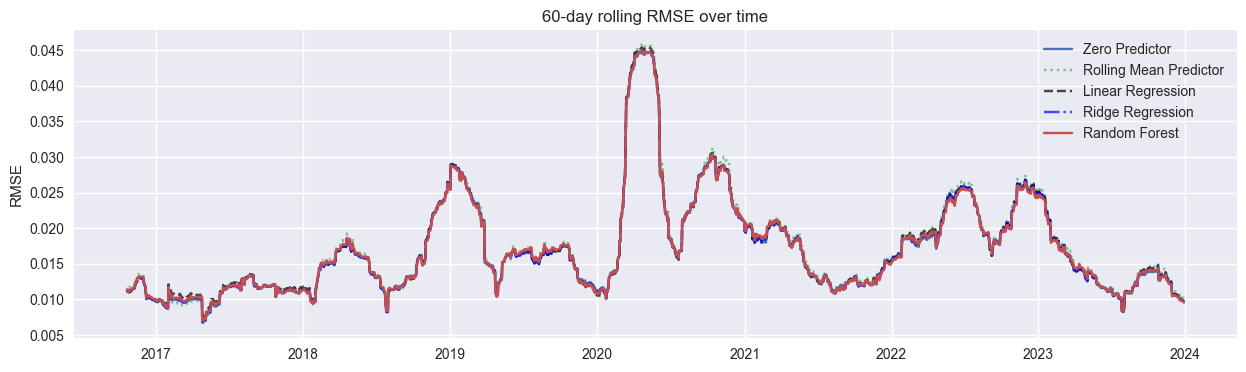

In [90]:
# TODO: plot rolling RMSE vs time for all models to compare their performance across different time periods/regimes

def get_rolling_rmse(actual, pred, win):
    squared_error = (actual - pred)**2
    return np.sqrt(squared_error.rolling(window=win).mean()).dropna()

window = 60
rmse_zero_roll = get_rolling_rmse(y_true, y_pred_zero, window)
rmse_roll_mean_roll = get_rolling_rmse(y_true, y_pred_rolling, window)
rmse_lr_roll = get_rolling_rmse(y_true, y_pred_lr, window)
rmse_ridge_roll = get_rolling_rmse(y_true, y_pred_ridge, window)
rmse_rf_roll = get_rolling_rmse(y_true, y_pred_rf, window)

plt.figure(figsize=(15, 4))
plt.plot(rmse_zero_roll, label='Zero Predictor')
plt.plot(rmse_roll_mean_roll, label='Rolling Mean Predictor', linestyle=':', alpha=0.7)
plt.plot(rmse_lr_roll, label='Linear Regression', color='black', linestyle='--', alpha=0.7)
plt.plot(rmse_ridge_roll, label='Ridge Regression', color='blue', linestyle='dashdot', alpha=0.7)
plt.plot(rmse_rf_roll, label='Random Forest')
plt.title(f'{window}-day rolling RMSE over time')
plt.ylabel('RMSE')
plt.legend()
plt.show()


In [91]:
# Bonus: compute volatility scaled/normalized prediction error: sqrt( ((y_true - y_pred)**2) / (vol_t**2) ) - and compare across models

vol_t = X['rolling_vol_20'].loc[test_index]

norm_err = {
    "Zero Predictor": (np.abs(y_true - y_pred_zero) / vol_t).mean(),
    "Rolling Mean": (np.abs(y_true - y_pred_rolling) / vol_t).mean(),
    "Linear Regression": (np.abs(y_true - y_pred_lr) / vol_t).mean(),
    "Ridge Regression": (np.abs(y_true - y_pred_ridge) / vol_t).mean(),
    "Random Forest": (np.abs(y_true - y_pred_rf) / vol_t).mean()
}

print("Comparison of models (highest to lowest normalized prediction error):")
for model, score in sorted(norm_err.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {score:.6f}")


Comparison of models (highest to lowest normalized prediction error):
Rolling Mean: 0.832926
Linear Regression: 0.817039
Random Forest: 0.812002
Ridge Regression: 0.806678
Zero Predictor: 0.805559


## 9. Bonus: Looking at a toy strategy based on predictions
Define a simple "all-in" strategy where you go all long (+1) when you predict the stock to be going up, and all short (-1) when you predict the stock to be going down
$$
\text{position}_t = \text{sign}(y_\text{pred})
$$
Then, your returns for the $t$-th day (assuming daily returns) will be $(\text{position}_t \times y_\text{true})$ (note $y_\text{true} = r_t$).

Note that this is extremely simplistic and ignore any predictions related magnitude of expected returns, or expected volatility data etc. It is used only as a demonstration of what a prediction-based strategy may look like.

**Plot your returns using this strategy based on all the models above and compare them!**

In [92]:
# TODO: compute the positions for each model and daily returns

strategy_df = pd.DataFrame(index=y_true.index)
strategy_df['Actual Return'] = y_true

predictions = {
    "Zero Predictor": y_pred_zero,
    "Rolling Mean": y_pred_rolling,
    "Linear Regression": pd.Series(y_pred_lr, index=y_true.index),
    "Ridge Regression": pd.Series(y_pred_ridge, index=y_true.index),
    "Random Forest": pd.Series(y_pred_rf, index=y_true.index),
}

for name, preds in predictions.items():
    pos_col = f'{name} Position'
    ret_col = f'{name} Return'
    strategy_df[pos_col] = np.sign(preds)
    strategy_df[ret_col] = strategy_df[pos_col] * strategy_df['Actual Return']
    strategy_df[f'{name} Cumulative Growth'] = np.exp(strategy_df[ret_col].cumsum()) # Not subtracting 1 here makes it current price if I invested $1 in the start


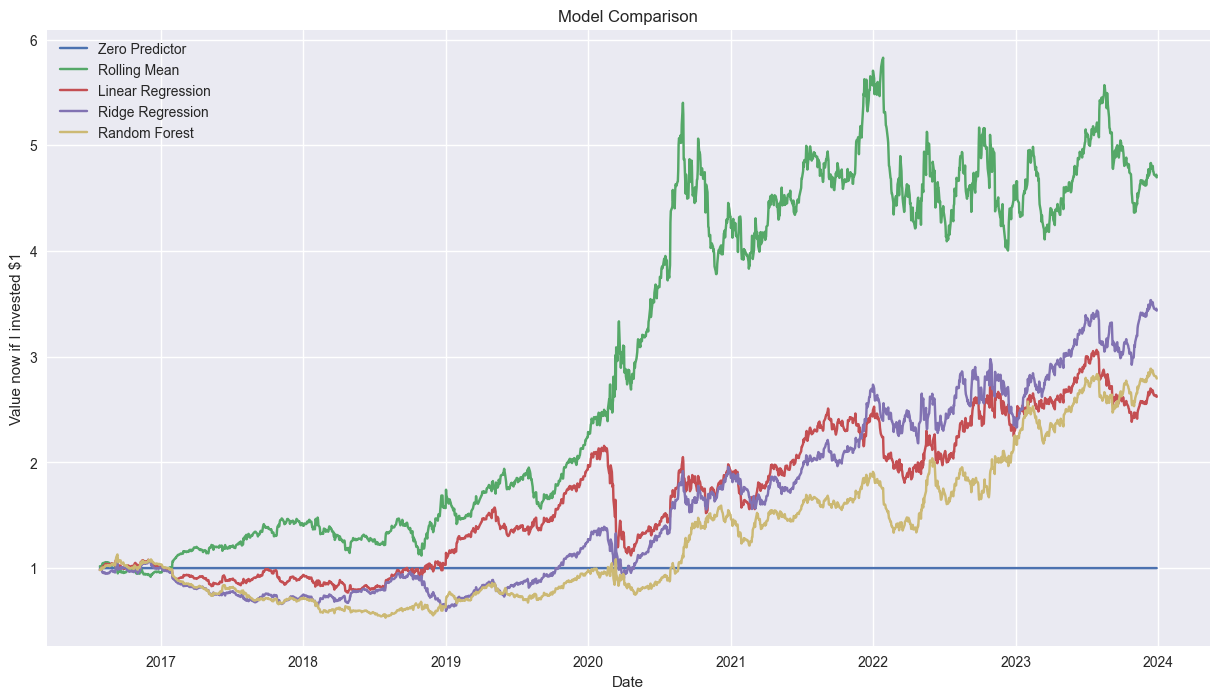

In [93]:
# TODO: plot your returns

plt.figure(figsize=(15, 8))
for i, name in enumerate(predictions.keys()):
    plt.plot(strategy_df[f'{name} Cumulative Growth'], label=name)

plt.title('Model Comparison')
plt.ylabel('Value now if I invested $1')
plt.xlabel('Date')
plt.legend()
plt.show()



## 10. Discussion questions

1. Why do we need naive baselines?
2. How does the evaluation strategy here (walk-forward evaluation) differ from the random training-test dataset splits used in convention ML?
3. *(Addon)* And, why does random splitting technique fail here?
4. Interpret the RMSE values and rolling RMSE plot results very briefly.
5. *(Addon)* Are there periods where model performance degrades noticeably? What might this indicate?
6. Why might Random Forest overfit?
7. *(Bonus)* Two models have similar RMSE, but one makes larger errors primarily during high-volatility periods. Why might this model be *less dangerous* in a portfolio context?

In [96]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']
data = yf.download(tickers, start="2018-01-01", end="2023-12-30", auto_adjust=False)['Adj Close']
log_returns = np.log(data / data.shift(1)).dropna()
Sigma_hat = log_returns.cov().values
print("Sigma_hat shape:", Sigma_hat.shape)
print(tickers)

[*********************100%***********************]  5 of 5 completed

Sigma_hat shape: (5, 5)
['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']


In [97]:
from sklearn import linear_model


mu_hat = []

for ticker in tickers:
    print(f"Training model for {ticker}...")
    df_asset = log_returns[[ticker]].copy()
    df_asset.columns = ['target']
    df_asset['lag1'] = df_asset['target'].shift(1)
    df_asset['lag2'] = df_asset['target'].shift(2)
    df_asset.dropna(inplace=True)

    X = df_asset.drop(columns=['target'])
    y = df_asset['target']
    
    train_size = int(len(df_asset) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    expected_return = np.mean(y_pred)
    
    mu_hat.append(expected_return)

mu_hat = np.array(mu_hat)
print("\nComputed Expected Returns (mu_hat):")
print(mu_hat)

Training model for AAPL...
Training model for MSFT...
Training model for GOOG...
Training model for AMZN...
Training model for TSLA...

Computed Expected Returns (mu_hat):
[0.00101532 0.00068408 0.00042511 0.00050701 0.00192685]


In [98]:
from helpers import save_predictions

print(f"mu_hat shape: {mu_hat.shape}")
print(f"Sigma_hat shape: {Sigma_hat.shape}")

# Save
# We save the LIST of tickers, not the array, to avoid pickling issues sometimes, 
# but np.array(tickers) is also fine as long as you load it correctly.
save_predictions(mu_hat, Sigma_hat, np.array(tickers))

print("Successfully saved multi-asset predictions to 'predictions.npz'.")

mu_hat shape: (5,)
Sigma_hat shape: (5, 5)
Successfully saved multi-asset predictions to 'predictions.npz'.
